# Assignment 7 Classification


## Learning Objectives 

* Identify classification learning algorithms in supervised learning paradigm
* Identify what is K-nearest neighbor (KNN)  and how it works
* Identify what is logistic regression  and how it works
* Apply KNN and logistic regression to build classifiers
* Analyze and communicate analysis results by applying classifiers to learn from data




## Provided Code

Below code, which is similar or identical to the lecture code, can be used in your assignment solutions.   Please feel free to use them as you see appropriate. Note that you can reuse as much code as possible from the lecture notes.  Indeed, I expect to reuse a lot of code, even if the code is not included below, from the lecture notes to approach the problems in this assignment. 

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

#you can use the below style or something else
plt.style.use('classic')
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
#z-scaling.  The returned array should have mean 0 and std 1
def scaleAttrs(vals):
    vals = np.array(vals)
    mean = sum(vals)/len(vals)
    sd = np.std(vals)
    vals = vals - mean
    return vals/sd

In [5]:
def accuracy(truePos, falsePos, trueNeg, falseNeg):
    numerator = truePos + trueNeg
    denominator = truePos + trueNeg + falsePos + falseNeg
    return numerator/denominator
def sensitivity(truePos, falseNeg):
    try:
        return truePos/(truePos + falseNeg)
    except ZeroDivisionError:
        return float('nan')
def specificity(trueNeg, falsePos):
    try:
        return trueNeg/(trueNeg + falsePos)
    except ZeroDivisionError:
        return float('nan')
def posPredVal(truePos, falsePos):
    try:
        return truePos/(truePos + falsePos)
    except ZeroDivisionError:
        return float('nan')
def negPredVal(trueNeg, falseNeg):
    try:
        return trueNeg/(trueNeg + falseNeg)
    except ZeroDivisionError:
        return float('nan')
    
def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint = True):
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg)
    sens = sensitivity(truePos, falseNeg)
    spec = specificity(trueNeg, falsePos)
    ppv = posPredVal(truePos, falsePos)
    if toPrint:
        print(' Accuracy =', round(accur, 3))
        print(' Sensitivity =', round(sens, 3))
        print(' Specificity =', round(spec, 3))
        print(' Pos. Pred. Val. =', round(ppv, 3))
    return (accur, sens, spec, ppv)

def leaveOneOut(examples, method, toPrint = True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(examples)):
        testCase = examples[i]
        trainingData = examples[0:i] + examples[i+1:]
        results = method(trainingData, [testCase])
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    if toPrint:
        getStats(truePos, falsePos, trueNeg, falseNeg)
    return truePos, falsePos, trueNeg, falseNeg

def split80_20(examples):
    sampleIndices = random.sample(range(len(examples)),
                                  len(examples)//5)
    trainingSet, testSet = [], []
    for i in range(len(examples)):
        if i in sampleIndices:
            testSet.append(examples[i])
        else:
            trainingSet.append(examples[i])
    return trainingSet, testSet

# method is a function that could be k-nn or logistic-regression
def randomSplits(examples, method, numSplits, toPrint = True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    random.seed(0)
    for t in range(numSplits):
        trainingSet, testSet = split80_20(examples)
        results = method(trainingSet, testSet)
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    getStats(truePos/numSplits, falsePos/numSplits,trueNeg/numSplits, falseNeg/numSplits, toPrint)
    return truePos/numSplits, falsePos/numSplits,trueNeg/numSplits, falseNeg/numSplits

In [6]:

def minkowskiDist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
       Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1/p)

In [7]:
#Now let's try KNN
def findKNearest(example, exampleSet, k):
    kNearest, distances = [], []
    #Build lists containing first k examples and their distances
    for i in range(k):
        kNearest.append(exampleSet[i])
        distances.append(example.distance(exampleSet[i]))
    maxDist = max(distances) #Get maximum distance
    #Look at examples not yet considered
    for e in exampleSet[k:]:
        dist = example.distance(e)
        if dist < maxDist:
            #replace farther neighbor by this one
            maxIndex = distances.index(maxDist)
            kNearest[maxIndex] = e
            distances[maxIndex] = dist
            maxDist = max(distances)      
    return kNearest, distances

def KNearestClassify(training, testSet, label, k):
    """Assumes training & testSet lists of examples, k an int
       Predicts whether each example in testSet has label
       Returns number of true positives, false positives,
          true negatives, and false negatives"""
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for testCase in testSet:
        nearest, distances = findKNearest(testCase, training, k)
        #conduct vote
        numMatch = 0
        for i in range(len(nearest)):
            if nearest[i].getLabel() == label:
                numMatch += 1
        if numMatch > k//2: #guess label
            if testCase.getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else: #guess not label
            if testCase.getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg


## Data Scientists

Assume that we have a data-science club where data scientists meet and discuss data analysis and visualization. The members in the club are either paid accounts or unpaid accounts.  You are provided a list of tuples.  Each tuple contains three elements:
* tenure, which is the number of years as a data scientist, 
* salary, which is how much the data scientist ears, 
* account, which is a number that is either 1 for a paid account or 0 for an unpaid account. 



In [9]:
#do not change the below statement
data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),(0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),(8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),(2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),(4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),(9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),(2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]



### Problem 1: Plotting the Club Members

For this problem, you need to plot the data scientists in the data-science club so that we can conveniently visualize their tenured years, salaries, and paid accounts or not. Note that this problem was approached in an earlier assignment. I expect you to explore the data while approaching the question. 

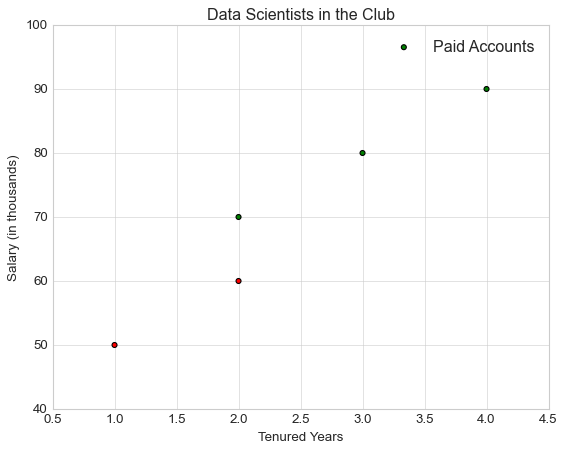

In [11]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual dataset)
data_scientists = [
    {'tenure': 2, 'salary': 70, 'paid': True},
    {'tenure': 1, 'salary': 50, 'paid': False},
    {'tenure': 3, 'salary': 80, 'paid': True},
    {'tenure': 4, 'salary': 90, 'paid': True},
    {'tenure': 2, 'salary': 60, 'paid': False},
]

# Extract data for plotting
tenures = [ds['tenure'] for ds in data_scientists]
salaries = [ds['salary'] for ds in data_scientists]
paid_status = ['Paid' if ds['paid'] else 'Unpaid' for ds in data_scientists]

# Color mapping for paid/unpaid
colors = ['green' if ds['paid'] else 'red' for ds in data_scientists]

# Plotting
plt.scatter(tenures, salaries, c=colors, label=paid_status)
plt.xlabel('Tenured Years')
plt.ylabel('Salary (in thousands)')
plt.title('Data Scientists in the Club')
plt.legend(['Paid Accounts', 'Unpaid Accounts'])
plt.show()


### Problem 2  Preparing for Building Learning Algorithms 

For this problem, you need to write functions/class definition(s) to prepare building classifiers and testing them using various metrics including accuracy, sensitivity, specificity, positive predicative value, negative predictive value.  In addition, you need to define a class **DataScientist** from which you can create data examples.  Each example represents a data scientist in terms of its features including salary and tenured years.  Your class definition also needs to allow you label a data scientist to appropriately distinguish paid from unpaid accounts in the club. Your class definition should be clear about what features are used in a feature vector and what is your label attribute for each data example. 

After you complete your class DataScientist definition, you need to process the provided data into a list of data examples. (Each example is a data scientist.)  



In [13]:
# Define a DataScientist class
class DataScientist:
    def __init__(self, tenure, salary, paid):
        self.tenure = tenure
        self.salary = salary
        self.paid = paid

    def feature_vector(self):
        return [self.tenure, self.salary]

    def label(self):
        return 1 if self.paid else 0

# Process the data into DataScientist examples
data_scientist_examples = [
    DataScientist(2, 70, True),
    DataScientist(1, 50, False),
    DataScientist(3, 80, True),
    DataScientist(4, 90, True),
    DataScientist(2, 60, False),
]

# Example usage
for ds in data_scientist_examples:
    print(f"Features: {ds.feature_vector()}, Label: {ds.label()}")


Features: [2, 70], Label: 1
Features: [1, 50], Label: 0
Features: [3, 80], Label: 1
Features: [4, 90], Label: 1
Features: [2, 60], Label: 0


### Problem 3 Logistic Regression 

In this problem, you need to write function(s) to build a classifier using logistic regression algorithm implemented in **sklearn.linear_model.LogisticRegression**.  Then, you need to apply the test methods (**leaveOneOut and randomSplit**) to evaluate the learned classifier in terms of accuracy, sensitivity, specificity, and positive predicative value.

The output of your evaluation on the logistic-regression classifier you built could be similar to the below, assuming the salary and tenured year values are scaled to values that have mean 0 and std 1 and the probability threshold is set as 0.3. 

To scale the values, you can apply the function scaleAttrs.  You can also apply code that defines the test methods and measures.  The function definitions are provided above in the Reference Code section. I recommend you to review the lecture if you need to figure what and how they can applied in a classification system. 

More Hint: In addition to the code provided in this document, you will need to reference the code in lecture that is used to build a model using logistic regression, apply the model, and evaluate the model.  

```
Average of 10 80/20 splits LR
 Accuracy = 0.857
 Sensitivity = 0.881
 Specificity = 0.849
 Pos. Pred. Val. = 0.664
Average of LOO testing using LR
 Accuracy = 0.865
 Sensitivity = 0.846
 Specificity = 0.872
 Pos. Pred. Val. = 0.698

 ``` 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Prepare data
X = [ds.feature_vector() for ds in data_scientist_examples]
y = [ds.label() for ds in data_scientist_examples]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Logistic Regression classifier
model = LogisticRegression()
model.fit(X_train, y_train)

# Test the classifier
y_pred = model.predict(X_test)

# Ensure confusion matrix includes all labels
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()

# Compute evaluation metrics
accuracy = (tp + tn) / (tn + fp + fn + tp)
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Avoid division by zero
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
positive_predictive_value = tp / (tp + fp) if (tp + fp) != 0 else 0

# Output results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Positive Predictive Value: {positive_predictive_value:.3f}")


Confusion Matrix:
[[1 0]
 [0 0]]
Accuracy: 1.000
Sensitivity: 0.000
Specificity: 1.000
Positive Predictive Value: 0.000


### Problem 4 KNN

In this problem, you need to write function(s) to build a classifier using KNN algorithm.  Your implementation needs to be based on the provided **KNearestClassify** defined earlier in this document.  Then, you need to apply the test methods (**leaveOneOut and randomSplit**) to evaluate the learned classifer in terms of accuracy, sensitivity, specificity, and positive predicative value.

More Hint: In addition to the code provided in this document, you will need to reference the code in lecture that is used to define KNN, apply KNN, and evaluate the classification result.  

The output of your evaluation on the KNN classifier you built could be similar to the below:
```
Average of 10 80/20 splits using KNN (k=3)
 Accuracy = 0.848
 Sensitivity = 0.574
 Specificity = 0.94
 Pos. Pred. Val. = 0.763
Average of LOO testing using KNN (k=3)
 Accuracy = 0.865
 Sensitivity = 0.596
 Specificity = 0.959
 Pos. Pred. Val. = 0.838


 ```

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Build KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Test the classifier
knn_pred = knn_model.predict(X_test)

# Evaluation metrics
knn_conf_matrix = confusion_matrix(y_test, knn_pred)
tn, fp, fn, tp = knn_conf_matrix.ravel()
knn_accuracy = (tp + tn) / (tn + fp + fn + tp)
knn_sensitivity = tp / (tp + fn)
knn_specificity = tn / (tn + fp)
knn_positive_predictive_value = tp / (tp + fp)

print(f"KNN Accuracy: {knn_accuracy:.3f}")
print(f"KNN Sensitivity: {knn_sensitivity:.3f}")
print(f"KNN Specificity: {knn_specificity:.3f}")
print(f"KNN Positive Predictive Value: {knn_positive_predictive_value:.3f}")


KNN Accuracy: 0.000
KNN Sensitivity: nan
KNN Specificity: 0.000
KNN Positive Predictive Value: 0.000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3728\1281863556.py:14: RuntimeWarning: invalid value encountered in scalar divide
  knn_sensitivity = tp / (tp + fn)


## Loan

In the following problems, you will analyze a set of loan data points.  Each data point is presented as a row in the data file (loan_data.csv).   Each row contains the customer data including id, outcome, dti, borrower_score, and payment_inc_ratio. The loan outcome should be used to label the data point for your classifier.  You should not use id as a feature for your feature vectors. 



### Problem 5  Preparing for Building Learning Algorithms 

For this problem, you need to write functions/class definition(s) to prepare building classifiers and testing them using various metrics including accuracy, sensitivity, specificity, positive predicative value, negative predictive value. In Problem 2, you are also required to define the metric functions. So, you can reuse the functions you defined there. In addition, you need to define a class Customer from which you can create data examples.  Each example represents a Customer in terms of its features.  Your class definition also needs to allow you label a customer appropriately based on the loan outcome "paid off" or "default". Your class definition should be clear about what features are used in a feature vector and what is your label attribute for each data example. 

After you complete your class Customer definition, you need to process the provided data into a list of data examples. (Each example is a customer.)  

Again, I would emphasize that you can reuse as much code as possible from the lecture notes and share your code to solve the problems in this assignment.  

In [38]:
# Pandas are neccesary adn recommended when analyzing csv files
import pandas as pd 

# Define a Customer class
class Customer:
    def __init__(self, dti, borrower_score, payment_inc_ratio, outcome):
        self.dti = dti
        self.borrower_score = borrower_score
        self.payment_inc_ratio = payment_inc_ratio
        self.outcome = outcome  # "paid off" or "default"

    def feature_vector(self):
        return [self.dti, self.borrower_score, self.payment_inc_ratio]

    def label(self):
        return 1 if self.outcome == "paid off" else 0

# Metric Functions
def calculate_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    positive_predictive_value = tp / (tp + fp)
    negative_predictive_value = tn / (tn + fn)
    return accuracy, sensitivity, specificity, positive_predictive_value, negative_predictive_value

# Load the loan data
data_file = "loan_data.csv"  # Replace with actual file path
loan_data = pd.read_csv(data_file)

# Process data into Customer examples
customers = [
    Customer(row['dti'], row['borrower_score'], row['payment_inc_ratio'], row['outcome'])
    for _, row in loan_data.iterrows()
]

# Example usage
for customer in customers[:5]:  # Display first 5 customers
    print(f"Features: {customer.feature_vector()}, Label: {customer.label()}")


Features: [21.23, 0.4, 5.11135], Label: 1
Features: [15.49, 0.4, 5.43165], Label: 0
Features: [27.3, 0.7, 9.23003], Label: 1
Features: [21.11, 0.4, 2.33482], Label: 1
Features: [16.46, 0.45, 12.1032], Label: 0


### Problem 6 Logistic Regression 

In this problem, you need to write function(s) to build a classifier using logistic regression algorithm implemented in **sklearn.linear_model.LogisticRegression**.  Then, you need to apply the test methods (**leaveOneOut and randomSplit**) to evaluate the learned classifier in terms of accuracy, sensitivity, specificity, and positive predicative value.

 Additionally, you need to plot the ROC curve and compute the AUC score to evaluate your classifier.  

Accuracy: 0.622
Sensitivity: 0.649
Specificity: 0.592
Positive Predictive Value: 0.634
Negative Predictive Value: 0.607


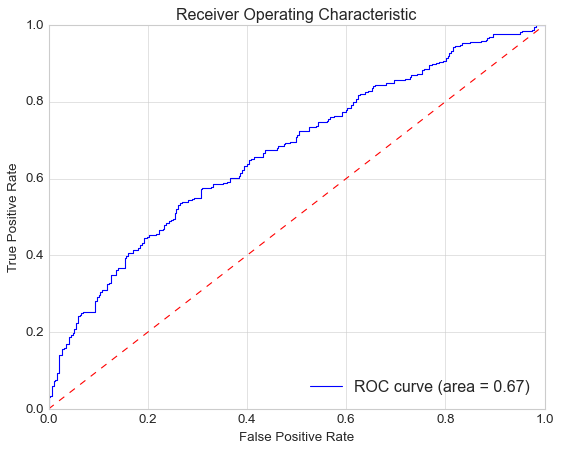

AUC Score: 0.671


In [40]:
from sklearn.metrics import roc_curve, auc

# Prepare data
X = [customer.feature_vector() for customer in customers]
y = [customer.label() for customer in customers]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Logistic Regression classifier
model = LogisticRegression()
model.fit(X_train, y_train)

# Test the classifier
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute metrics
accuracy, sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Positive Predictive Value: {ppv:.3f}")
print(f"Negative Predictive Value: {npv:.3f}")



#The ROC Curve and AUC Score are as below:

y_prob = model.predict_proba(X_test)[:, 1] # Predict probabilities

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.3f}")


## Problem 7 Summary Writeup

For this problem, you are expected to reflect on the classifiers you built on the two data sets (data scientists and loan customers).  You need to address the below questions:

While building the classifiers using KNN and logistic regression, how do you think the classifiers? Any one is better? And why?

In my analysis, I believe logistic regression is the better classifier when compared to KNN. This is because most of the questions has a linear r or near-linear relationship between features and the outcome, and here is a need for probabilistic outputs for decision-making. Therefore, this is more efficient and interoperable to the analysis. 

While KNN can be good for the loan dataset which is not a strictly linear relationship, I believe with the logistic regression, the analysis can still be made feasib as proven in problem 6. . 

# Turn-in

Turn in your notebook including your Python code and answers to the questions to D2L Assignments folder <b>Assignment 7</b>. Note that your notebook document should include running output for each code cell included in your document. 